In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, laplace, beta
from statsmodels.graphics.tsaplots import plot_acf
import warnings 
warnings.filterwarnings('ignore')

# Úvod do MCMC a pravděpodobnostního programování

*Teorie Markovských řetězců je obsahem MI-SPI, nebudeme zde tedy zabíhat do detailů a soustředíme se na vzorkovací algoritmy.*

### Markovský řetězec

Markovským řetězcem $\{X_t\}$ je posloupnost závislých náhodných veličin $X_1, X_2,\ldots,X_t$ takových, že každá veličina $X_{t}$ závisí pouze na veličině $X_{t-1}$. Přechodovou pravděpodobnost popisuje markovské jádro

$$
X_{t+1}|X_{t}, X_{t-1},\ldots,X_{0} \sim K(X_{t}, X_{t+1}).
$$

Jádro $K(X_t, X_{t+1})$ popisující přechod ze stavu $X_t$ do $X_{t+1}$ je zpravidla reprezentováno podmíněnou hustotou pravděpodobnosti $q(x_{t+1}|x_t)$.

> **Příklad**
>
> Uvažujme gaussovskou náhodnou procházku 
>
>$$X_{t+1} = X_t + \varepsilon_t, \qquad \varepsilon_t\sim\mathcal{N}(0, 1).$$
>
> Potom 
>
> $$K(X_t, X_{t+1}) \equiv \mathcal{N}(X_t, 1).$$
>
> *Následující kód vygeneruje dvě náhodné procházky, jednu podle aditivního vztahu, druhý přímým využitím jádra.*

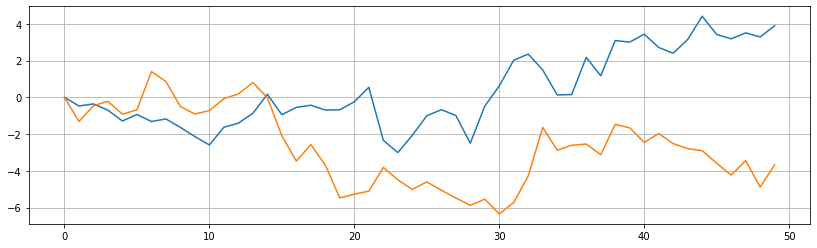

In [6]:
ndat = 50
x = np.zeros(ndat)
X = np.zeros(ndat)
for t in range(ndat-1):
    x[t+1] = x[t] + norm.rvs(loc=0, scale=1)
    X[t+1] = norm.rvs(loc=X[t], scale=1)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.plot(X)
plt.show()

Markovské řetězce v MCMC mají z principu konstrukce jisté atraktivní vlastnosti.
Např. existenci stacionární distribuce $f$, která zajišťuje, že pokud $X_t \sim f$, potom i $X_{t+1}\sim f$. Postačující (nikoliv nutnou) podmínkou stacionarity je **reverzibilita** markovského řetězce

$$
f(x)\,K(x, y) = f(y)\,K(y,x),
$$

v řeči hustot

$$
f(x) q(y|x) = f(y)q(x|y).
$$

Další vlastností je **ireducibilita**, zajišťující, že přechodové jádro $K(x,y)$ umožňuje pohyb po celém stavovém prostoru bez ohledu na počáteční stav, tj. že pravděpodobnost dosažení libovolné hodnoty stavového prostoru je kladná, ať už je hodnota $X_0$ jakákoliv. **Rekurence** zajišťuje, že střední hodnota počtu "návštěv" určitého stavu je nekonečná a stav bude dosažen v konečném čase. Velmi významným pojmem je **ergodicita**.

## Markov chain Monte Carlo (MCMC)

Nosnou myšlenkou MCMC lze vyjádřit v těchto bodech:
1. Máme cílovou (target) distribuci s hustotou $f$, kterou chceme aproximovat vzorky.
2. Sestavíme markovské jádro $K(X_t, X_{t+1})$, jehož stacionární distribucí je právě $f$.
3. Vygenerujeme markovský řetězec $\{X_t\}$.

Jako markovské jádro můžeme použít nějakou vhodnou hustotu $q(y|x)$, z níž lze dobře vzorkovat. Požadavků na tuto hustotu je relativně málo. Měla by např. mít dostatečně velkou varianci, aby bylo možné "prozkoumat" celý nosič $f$. K některým vlastnostem se dostaneme záhy...

### Metropolisův-Hastingsův algoritmus

> **Metropolisův-Hastingsův algoritmus**
>
> Inicializace: Zvol vhodné $x_0$ a proposal $q(y|x)$.
>
> Pro $t=1,2,\ldots$:
>
> 1. Vygeneruj $x'$ z proposalu $q(x'|x_t)$.
> 2. Spočti pst přijetí (přechodu $x' \leftarrow x_t$):
>
>$$
\alpha = \min \left(1, \frac{f(x')}{f(x_t)}\frac{q(x_t|x')}{q(x'|x_t)} \right).
$$
>
> 3. Vygeneruj $u\sim\mathcal{U}(0,1)$.
> 4. Je-li $u \leq \alpha$, přijmi vzorek: $x_{t+1} = x'$. Jinak kopíruj $x_{t+1}=x_t$.

Za povšimnutí stojí 2. krok v algoritmu, ve kterém se počítá pravděpodobnost přijetí vzorku. Pokud použijeme symetrický proposal, např. normální distribuci (nebo Laplaceovu, Cauchyho, symetrickou trojúhelníkovou atd.), potom funkce v čitateli má stejnou hodnotu, jako funkce ve jmenovateli a celý krok jde zjednoduššit na

$$
\alpha = \min\left(1, \frac{f(x')}{f(x_t)}\right),
$$

neboť druhý zlomek obsahuje v čitateli a ve jmenovateli stejné hodnoty díky symetrii proposalu. To názorně demonstruje následující obrázek.

Algoritmus se symetrickým proposalem zjednodušující výpočet $\alpha$ se nazývá **Metropolisův**.

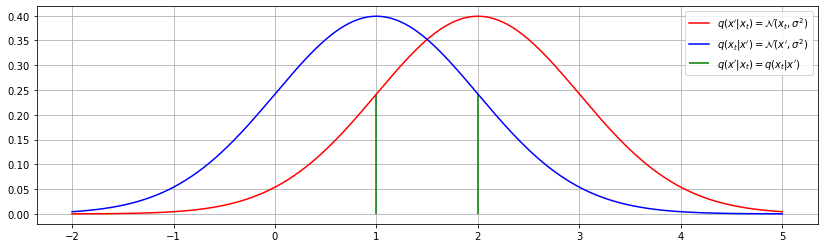

In [170]:
xt = 2
x_candidate = 1
proposal_scale = 1

xticks = np.linspace(-2, 5, 1000)
plt.figure(figsize=(14,4))
plt.plot(xticks, norm.pdf(xticks, loc=xt, scale=proposal_scale), 'r', label=r"$q(x'|x_t) = \mathcal{N}(x_t,\sigma^2)$")
plt.plot(xticks, norm.pdf(xticks, loc=x_candidate, scale=proposal_scale), 'b', label=r"$q(x_t|x')=\mathcal{N}(x',\sigma^2)$")
plt.vlines(x_candidate, ymin=0, ymax=norm.pdf(xt, loc=x_candidate, scale=proposal_scale), color='green', label=r"$q(x'|x_t)=q(x_t|x')$")
plt.vlines(xt, ymin=0, ymax=norm.pdf(x_candidate, loc=xt, scale=proposal_scale), color='green')
plt.legend()
plt.show()

#### Příklad

Zkusme jako příklad generovat vzorky z [Laplaceovy distribuce](https://en.wikipedia.org/wiki/Laplace_distribution). Jako proposal použijme normální distribuci centrovanou v posledním vzorku se směrodatnou odchylkou `proposal_scale`. Jako cvičení zkuste tuto směrodatnou odchylku měnit a pozorovat, co to dělá s traceplotem a s histogramem. Podobně pracujte s délkou řetězce (`nsamples`).

In [11]:
target = laplace()
proposal = norm
proposal_scale = 1

nsamples = 10000
x = np.zeros(nsamples)

for t in range(nsamples-1):
    x_candidate = proposal.rvs(loc=x[t], scale=proposal_scale)
    fraction = target.pdf(x_candidate) * proposal.pdf(x[t], loc=x_candidate, scale=proposal_scale)
    fraction /= target.pdf(x[t]) * proposal.pdf(x_candidate, loc=x[t], scale=proposal_scale)
    alpha = np.min([1, fraction])
    u = uniform.rvs()
    if u <= alpha:
        x[t+1] = x_candidate
    else:
        x[t+1] = x[t]

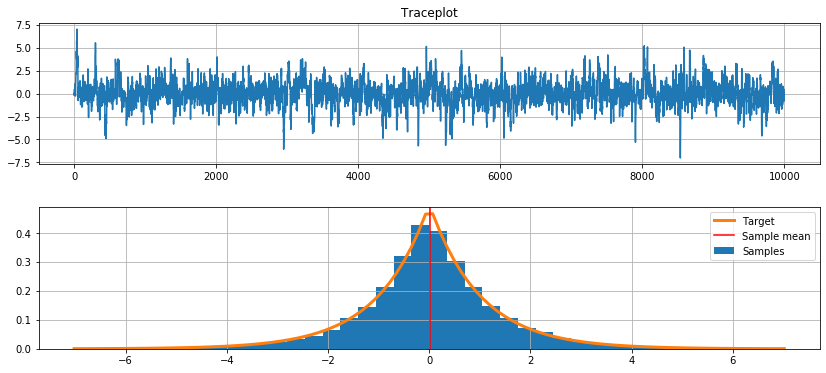

In [12]:
plt.figure(1, figsize=(14,6))
plt.subplot(211)
plt.plot(x)
plt.title("Traceplot")
plt.subplot(212)
plt.hist(x, bins=40, density=True, label='Samples')
plt.plot(np.linspace(x.min(), x.max(),100), target.pdf(np.linspace(x.min(),x.max(),100)), lw=3, label='Target')
plt.axvline(x.mean(), color='red', label='Sample mean')
plt.legend()

### Autokorelace a thinning

Už víme, že díky využití přechodového jádra jsou vzorky vzájemně korelované (závislé). Podívejme se na autokorelační funkci (ACF), vyjadřující lineární korelační koeficient pro řetězec ve dvou časových okamžicích $t$ a $t-k$,

$$
r(X_t, X_{t-k}) = \frac{\operatorname{cov}(X_t, X_{t-k})}{\sqrt{\operatorname{var}X_t \cdot \operatorname{var} X_{t-k}}}.
$$

Pokud si vykreslíme ACF, dostaneme něco takovéhoto:

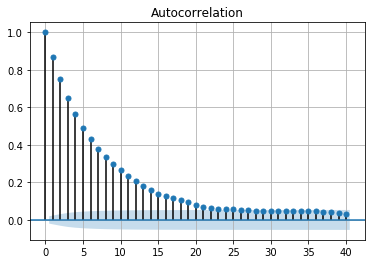

In [13]:
plot_acf(x)
plt.show()

Vzorky z cílové (target) distribuce tedy nejsou nezávislé, což nám poněkud překáží. S cílem zredukovat tuto autokorelaci často používáme tzv. **thinning** - vybereme každý $n$tý vzorek z řetězce. Tím vznikne podřetězec s menší mírou autokorelace. Není to úplně ideální řešení, neboť autokorelovanost sice snižuje, ale nepotlačuje, navíc za cenu značné režie, neboť značné množství vzorků je po vygenerování zahozeno. Z hlediska úspory paměti je výhodné použít thinning přímo při generování řetězce, spíše než redukovat výsledný řetězec.


Zkusme trochu experimentovat s thinningem řetězce z předchozí simulace:

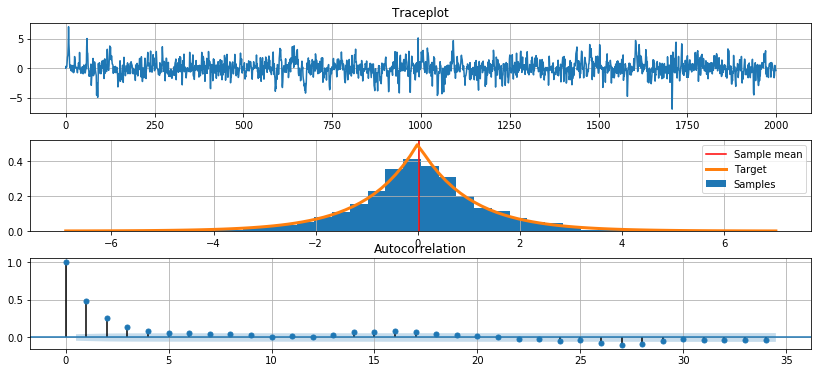

In [14]:
thinning = 5
x_thinned = x[::thinning]
plt.figure(1, figsize=(14,6))
plt.subplot(311)
plt.plot(x_thinned)
plt.title("Traceplot")
plt.subplot(312)
plt.hist(x_thinned, bins=40, density=True, label='Samples')
plt.axvline(x_thinned.mean(), color='red', label='Sample mean')
plt.plot(np.linspace(x_thinned.min(), x_thinned.max(),100), 
         target.pdf(np.linspace(x_thinned.min(),x_thinned.max(),100)),
         lw=3, label='Target')
plt.legend()
ax = plt.subplot(313)
plot_acf(x_thinned, ax=ax);
plt.show()

### Volba markovského jádra

Volba markovského (přechodového) jádra $K(X_t, X_{t+1})$ resp. podmíněné hustoty $q(\cdot|x_{t-1})$ naráží na úskalí zmíněné autokorelace. Ta má dva zdroje:
1. korelace mezi současným stavem $X_t$ a stavem nově navrženým $X_{t+1}\sim K(X_t, X_{t+1})$,
2. korelace v důsledku setrvání na stejném stavu, $X_{t+1} = X_t$, kvůli zamítnutí nového vzorku.

Ideálem by byla taková proposal distribuce (jádro), která by umožnila rychlé změny $X_t$ a současně měla vysokou akceptanci, tedy podíl přijatých vzorků. Tyto dva cíle jdou ale proti sobě. Pokud zvolíme příliš koncentrovaný proposal s malým rozptylem, bude vysoká akceptance, ovšem za cenu vysoké autokorelace. Pokud se naopak přikloníme k velkému rozptylu proposalu, bude řetězec lépe přeskakovat na "větší vzdálenosti", ovšem za cenu mnoha zahozených a tedy i mnoha opakovaných vzorků.

Toto je jeden z důvodů, proč nás zajímá *trace plot*. Vágně řečeno, pokud vidíme v trajektorii výraznější trend, je zvolený proposal příliš koncentrovaný. Naopak, je-li trajektorie příliš často konstantní, tj. nedochází k přeskokům řetězce, je proposal příliš široký.

Následující příklad demonstruje zmíněné efekty. Cílová (target) distribuce je standardní normální distribuce $\mathcal{N}(0,1)$, použijeme tři normální přechodová jádra se směrodatnými odchylkami 0.01, 1 a 100.

In [175]:
target = norm(loc=0, scale=1)
proposals = [norm, norm, norm]
proposals_scales = [.01, 1., 100.]

nsamples = 1000
xs = np.zeros((3, nsamples))
xs_rej = []

for t in range(nsamples-1):
    for i, (proposal, scale) in enumerate(zip(proposals, proposals_scales)):
        x_candidate = proposal.rvs(loc=xs[i,t], scale=scale)
        fraction = target.pdf(x_candidate) / target.pdf(xs[i,t])
        u = uniform.rvs()
        if u <= np.min([1, fraction]):
            xs[i,t+1] = x_candidate
        else:
            xs[i,t+1] = xs[i,t]

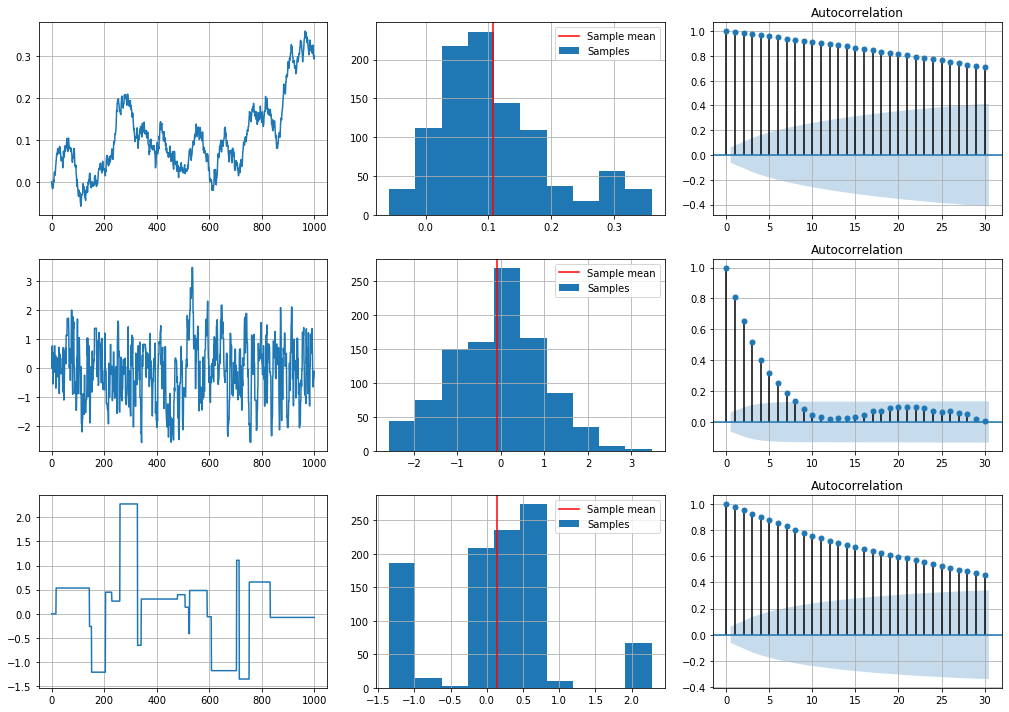

In [176]:
plt.figure(figsize=(14,10))
for i in range(len(proposals)):
    plt.subplot(3,3,3*i+1)
    plt.plot(xs[i])
    plt.subplot(3,3,3*i+2)
    plt.hist(xs[i], label='Samples')
    plt.axvline(xs[i].mean(), color='red', label='Sample mean')
    plt.legend()
    plt.subplot(3,3,3*i+2)
    ax = plt.subplot(3,3,3*i+3)
    plot_acf(xs[i], ax=ax);
plt.tight_layout()

#### Burn-in

Je-li $x_0$ zvoleno mimo oblast, kde je cílová hustota koncentrována, řetězec pro více či méně počátečních kroků generuje vzorky mimo stacionární distribuci. Tomuto úseku se říká "burn-in". Takové vzorky se obvykle zahodí.

Samozřejmě pokud nastavíme počáteční hodnotu hodně mimo, případně zvolíme nevhodné jádro, potom ke konvergenci řetězce nemusí dojít vůbec.

Následující příklad demonstruje burn-in na příkladu vzorkování z $\mathcal{N}(\mu, 1)$, kde střední hodnotu $\mu$ úmyslně dáme vzdálenější od počátku řetězce. Samozřejmě v praxi je problém opačný - cílová distribuce je fixní a my nevhodně nastavíme počátek řetězce.

In [15]:
target = norm(loc=20)
proposal = norm
proposal_scale = 1

nsamples = 1000
x = np.zeros(nsamples)

for t in range(nsamples-1):
    x_candidate = proposal.rvs(loc=x[t], scale=proposal_scale)
    fraction = target.pdf(x_candidate) * proposal.pdf(x[t], loc=x_candidate, scale=proposal_scale)
    fraction /= target.pdf(x[t]) * proposal.pdf(x_candidate, loc=x[t], scale=proposal_scale)
    alpha = np.min([1, fraction])
    u = uniform.rvs()
    if u <= alpha:
        x[t+1] = x_candidate
    else:
        x[t+1] = x[t]

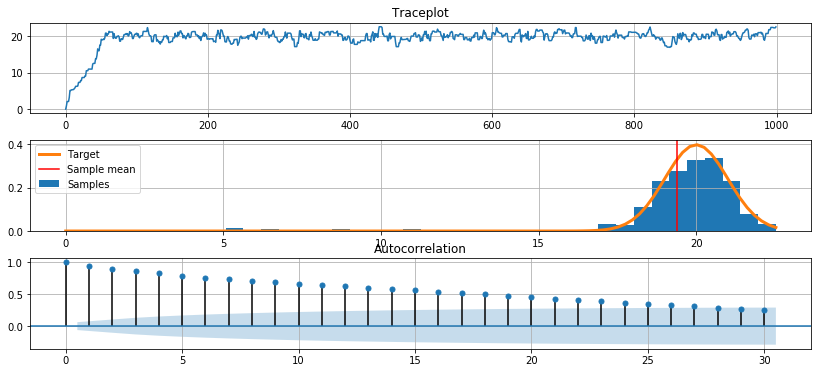

In [17]:
plt.figure(1, figsize=(14,6))
plt.subplot(311)
plt.plot(x)
plt.title("Traceplot")
plt.subplot(312)
plt.hist(x, bins=40, density=True, label='Samples')
plt.plot(np.linspace(x.min(), x.max(),100), target.pdf(np.linspace(x.min(),x.max(),100)), lw=3, label='Target')
plt.axvline(x.mean(), color='red', label='Sample mean')
plt.legend()
ax = plt.subplot(313)
plot_acf(x, ax=ax);

Pokud bychom tedy využili *burn-in* i *thinning*, měli bychom něco takovéhoto:

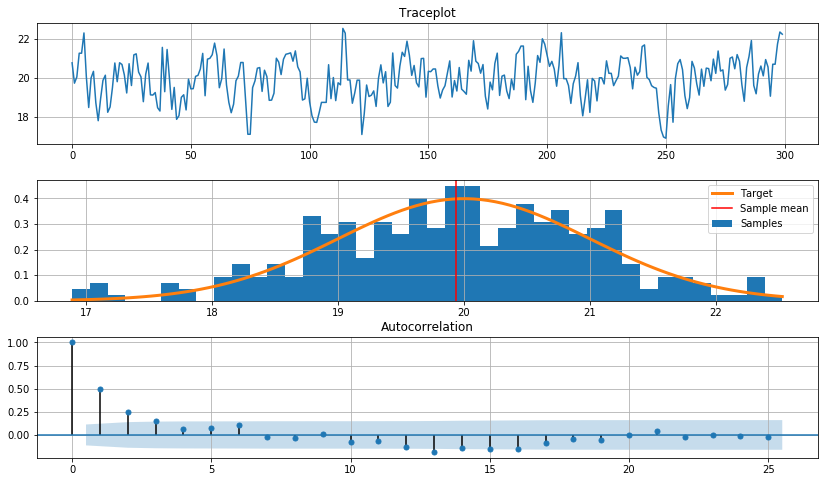

In [18]:
burnin = 100
thinning = 3

x_final = x[burnin::thinning]
plt.figure(1, figsize=(14,8))
plt.subplot(311)
plt.plot(x_final)
plt.title("Traceplot")
plt.subplot(312)
plt.hist(x_final, bins=40, density=True, label='Samples')
plt.plot(np.linspace(x_final.min(), x_final.max(),100), 
         target.pdf(np.linspace(x_final.min(),x_final.max(),100)), lw=3, label='Target')
plt.axvline(x_final.mean(), color='red', label='Sample mean')
plt.legend()
ax = plt.subplot(313)
plot_acf(x_final, ax=ax);

### Monitorování konvergence

Už víme, že u MCMC potřebujeme nastavit:
1. *jádro* - jeho distribuci (např. normální) a parametry (např. varianci),
2. *burn-in* - počet počátečních zahozených vzorků,
3. *thinning* - periodu výběru vzorků z generovaného řetězce.

S vygenerovaným řetězcem potřebujeme ale udělat nějaké ex post analýzy, zda zkonvergoval. K tomu slouží celá řada technik, z nichž nejčastější jsou:
1. Vizuální zhodnocení trace plotů, autokorelací a histogramů.
2. Porovnání několika řetězců - generování se spustí z různých bodů a zjišťuje se, zda různé řetězce zkonvergovaly ke stejným distribucím. Často se používá Kolmogorovův-Smirnovův (KS) test.
3. Neparametrické testy podřetězců - řetězec se rozdělí na několik částí a testuje se, zda mají stejné rozdělení. Často se používá Kolmogorovův-Smirnovův (KS) test.
4. Riemannovy sumy - využívá se faktu, že 

$$\int f(x) dx = 1.$$

Čím lépe tedy řetězec navzorkoval hustotu $f$, tím blíže je jedné i Monte Carlo aproximace tohoto integrálu

$$\sum_{t=2}^{T} (x_t - x_{t-1}) f(x_t).$$

Problematika konvergence a vhodného nastavení MCMC vzorkování je velmi široká. My se v rámci BML spokojíme s tímto "minimem" :-)

## Fixní proposal distribuce

Podívejme se na následující MH algoritmus s fixovaným proposalem, nezávislým na aktuální hodnotě vzorku:

> **Independent Metropolis-Hastings algorithm**
>
> Inicializace: Zvol vhodné $x_0$ a proposal $g(y) = q(y|x)$.
>
> Pro $t=1,2,\ldots$:
>
> 1. Vygeneruj $x'$ z proposalu $g(x') = q(x'|x_t)$.
> 2. Spočti pst přijetí (přechodu $x' \leftarrow x_t$):
>
>$$
\alpha = \min \left(1, \frac{f(x')}{f(x_t)}\frac{g(x_t)}{g(x')} \right).
$$
>
> 3. Vygeneruj $u\sim\mathcal{U}(0,1)$.
> 4. Je-li $u \leq \alpha$, přijmi vzorek: $x_{t+1} = x'$. Jinak $x_{t+1}=x_t$.

Lze ukázat, že takovýhle algoritmus má dobré podmínky, pokud pro cílovou hustotu $f(x)$ a proposal $g(x)$ existuje kladná konstanta $M$ taková, že pro všechna $x$ z nosiče $f(x)$ platí

$$
f(x) \leq M g(x).
$$

Připomíná vám to něco? Ano, rejection sampling algoritmus z dřívějších přednášek. Ale stále to není totéž:

- Rejection sampling generuje iid vzorky, zatímco vzorky z uvedeného MH nejsou nezávislé s výjimkou triviálního případu $f=g$. Tato závislost plyne jednoduše z principu, kdy přijetí nového vzorku závisí na hodnotě vzorku předchozího.
- Independent MH algoritmus opakuje stávající vzorek, dokud nedojde k přechodu.
- Uvedený MH algoritmus nepotřebuje určit hodnotu $M$, jejíž výpočet (odhad) může být poměrně náročný.

Zkusme jako příklad generovat vzorky ze (známé) beta distribuce. Jako proposal použijeme pro úplnou jednoduchost rovnoměrnou distribuci U(0,1). Mohli bychom dokonce zjednoduššit zlomek pro výpočet $\alpha$, ale nechme ho takto. Za úkol zkuste proposal nahradit trojúhelníkovou distribucí (`scipy.stats.triang`).

In [19]:
target = beta(a=5, b=7)
proposal = uniform(0, 1)

nsamples = 5000
x = np.zeros(nsamples)

for t in range(nsamples-1):
    x_candidate = proposal.rvs()
    fraction = target.pdf(x_candidate) * proposal.pdf(x[t])
    fraction /= target.pdf(x[t]) * proposal.pdf(x_candidate)
    alpha = np.min([1, fraction])
    u = uniform.rvs()
    if u <= alpha:
        x[t+1] = x_candidate
    else:
        x[t+1] = x[t]

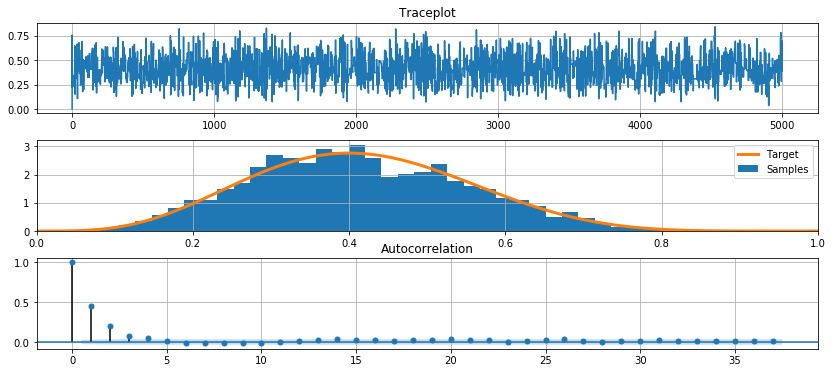

In [20]:
plt.figure(1, figsize=(14,6))
plt.subplot(311)
plt.plot(x)
plt.title("Traceplot")
plt.subplot(312)
plt.hist(x, bins=40, density=True, label='Samples')
plt.plot(np.linspace(0,1,100), target.pdf(np.linspace(0,1,100)), lw=3, label='Target')
plt.xlim((0, 1))
plt.legend()
ax = plt.subplot(313)
plot_acf(x, ax=ax);